# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [1]:
# 필요한 라이브러리를 설치합니다.
# !pip install timm
# !pip install matplotlib
# !pip install seaborn
# !pip install optuna

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [2]:
import os
import time
import random
import copy

import optuna, math
import timm
import torch
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.cuda.amp import autocast, GradScaler  # Mixed Precision용

from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold

def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


from collections import Counter
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

# 한글 폰트 설정 (시각화용)
plt.rcParams['font.family'] = ['DejaVu Sans']

In [7]:
# [추가] 노트북 로거 설정
# 결과 저장을 위한 로거 초기화
import sys
import os
sys.path.append('../../../')  # 프로젝트 루트로 경로 추가

from src.logging.notebook_logger import create_notebook_logger

# 프로젝트 루트 디렉토리 찾기
current_dir = os.getcwd()
if 'notebooks/team/KBH' in current_dir:
    project_root = current_dir.replace('/notebooks/team/KBH', '')
else:
    project_root = os.path.abspath('../../../')

# 절대 경로로 팀 노트북 로거 초기화
base_log_path = os.path.join(project_root, "notebooks/team")
logger = create_notebook_logger(
    base_log_dir=base_log_path,
    folder_name="KBH", 
    file_name="F1_0_934_swinb"
)

print("✅ 노트북 로거 설정 완료!")
print(f"📁 로그 경로: {logger.log_dir}")

📝 노트북 작업 시작: F1_0_934_swinb
📝 로그 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/team/KBH/F1_0_934_swinb/20250908_095705
✅ 노트북 로거 설정 완료!
📁 로그 경로: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/team/KBH/F1_0_934_swinb/20250908_095705/logs


In [6]:
# 로거 경로 확인
print(f"실제 기본 디렉토리: {logger.base_dir}")
print(f"로그 디렉토리: {logger.log_dir}")
import os
print(f"현재 작업 디렉토리: {os.getcwd()}")

# 디렉토리 존재 확인
if logger.log_dir.exists():
    print(f"✅ 로그 디렉토리 존재함: {logger.log_dir}")
else:
    print(f"❌ 로그 디렉토리 없음: {logger.log_dir}")

실제 기본 디렉토리: notebooks/team/KBH/F1_0_934_swinb/20250908_095307
로그 디렉토리: notebooks/team/KBH/F1_0_934_swinb/20250908_095307/logs
현재 작업 디렉토리: /home/ieyeppo/AI_Lab/computer-vision-competition-1SEN/notebooks/team/KBH
✅ 로그 디렉토리 존재함: notebooks/team/KBH/F1_0_934_swinb/20250908_095307/logs


In [3]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [4]:
# 데이터셋 클래스를 정의합니다. (Hard Augmentation 포함)
class ImageDataset(Dataset):
    def __init__(self, data, path, epoch=0, total_epochs=10, is_train=True):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.epoch = epoch
        self.total_epochs = total_epochs
        self.is_train = is_train
        
        # Hard augmentation 확률 계산
        self.p_hard = 0.2 + 0.3 * (epoch / total_epochs) if is_train else 0
        
        # Normal augmentation
        self.normal_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
            ], p=0.6),
            A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.8),
            A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
        
        # Hard augmentation
        self.hard_aug = A.Compose([
            A.LongestMaxSize(max_size=img_size),
            A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
            A.OneOf([
                A.Rotate(limit=[90,90], p=1.0),
                A.Rotate(limit=[180,180], p=1.0),
                A.Rotate(limit=[270,270], p=1.0),
                A.Rotate(limit=[-15,15], p=1.0),
            ], p=0.8),
            A.OneOf([
                A.MotionBlur(blur_limit=15, p=1.0),
                A.GaussianBlur(blur_limit=15, p=1.0),
            ], p=0.95),
            A.RandomBrightnessContrast(brightness_limit=0.5, contrast_limit=0.5, p=0.9),
            A.GaussNoise(var_limit=(50.0, 150.0), p=0.8),
            A.JpegCompression(quality_lower=70, quality_upper=100, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 배치별 증강 선택
        if self.is_train and random.random() < self.p_hard:
            img = self.hard_aug(image=img)['image']
        else:
            img = self.normal_aug(image=img)['image']
        
        return img, target

In [5]:
# one epoch 학습을 위한 함수입니다.
def train_one_epoch(loader, model, optimizer, loss_fn, device):
    scaler = GradScaler()  # Mixed Precision용
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for image, targets in pbar:
        image = image.to(device)
        targets = targets.to(device)
        
        # Cutmix/Mixup 적용 (30% 확률)
        if random.random() < 0.3:
            mixed_x, y_a, y_b, lam = mixup_data(image, targets, alpha=1.0)
            with autocast(): preds = model(mixed_x)
            loss = lam * loss_fn(preds, y_a) + (1 - lam) * loss_fn(preds, y_b)
        else:
            with autocast(): preds = model(image)
            loss = loss_fn(preds, targets)

        model.zero_grad(set_to_none=True)

        scaler.scale(loss).backward()  # Mixed Precision용
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer); scaler.update()  # Mixed Precision용

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [ ]:
# [추가] 하이퍼파라미터 설정 저장
# 현재 실험 설정을 저장
hyperparams = {
    'model_name': model_name,
    'img_size': img_size,
    'lr': LR,
    'epochs': EPOCHS,
    'batch_size': BATCH_SIZE,
    'num_workers': num_workers,
    'n_folds': N_FOLDS,
    'use_optuna': USE_OPTUNA,
    'seed': SEED
}

# 하이퍼파라미터 저장
logger.save_json(hyperparams, 'hyperparameters', '실험 하이퍼파라미터 설정')

print("✅ 하이퍼파라미터 설정 저장 완료!")
print(f"📊 모델: {model_name}, 이미지 크기: {img_size}, 배치 크기: {BATCH_SIZE}")

In [6]:
# validation을 위한 함수 추가
def validate_one_epoch(loader, model, loss_fn, device):
    """
    한 에폭 검증을 수행하는 함수
    - model.eval()로 모델을 평가 모드로 전환
    - torch.no_grad()로 gradient 계산 비활성화하여 메모리 절약
    - 검증 데이터에 대한 loss, accuracy, f1 score 계산
    """
    model.eval()  # 모델을 평가 모드로 전환 (dropout, batchnorm 비활성화)
    val_loss = 0
    preds_list = []
    targets_list = []
    
    with torch.no_grad():  # gradient 계산 비활성화로 메모리 절약
        pbar = tqdm(loader, desc="Validating")
        for image, targets in pbar:
            image = image.to(device)
            targets = targets.to(device)
            
            preds = model(image)  # 모델 예측
            loss = loss_fn(preds, targets)  # 손실 계산
            
            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())  # 예측 클래스 저장
            targets_list.extend(targets.detach().cpu().numpy())  # 실제 클래스 저장
            
            pbar.set_description(f"Val Loss: {loss.item():.4f}")
    
    val_loss /= len(loader)  # 평균 손실 계산
    val_acc = accuracy_score(targets_list, preds_list)  # 정확도 계산
    val_f1 = f1_score(targets_list, preds_list, average='macro')  # Macro F1 계산 (대회 평가지표)
    
    ret = {
        "val_loss": val_loss,
        "val_acc": val_acc,
        "val_f1": val_f1,
    }
    
    return ret

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# data config
data_path = '../data/'

# model config
# model_name = 'tf_efficientnetv2_b3' # 'resnet50' 'efficientnet-b0', ...
model_name = 'swin_base_patch4_window12_384_in22k'

# training config
img_size = 384
LR = 5e-4
EPOCHS = 20
BATCH_SIZE = 32
num_workers = 30

In [8]:
# Optuna를 사용한 하이퍼파라미터 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    def objective(trial):
        lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
        batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
        
        # 간단한 3-fold CV로 빠른 평가
        skf_simple = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        fold_scores = []
        
        for fold, (train_idx, val_idx) in enumerate(skf_simple.split(train_df, train_df['target'])):
            # 모델 생성
            model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
            optimizer = Adam(model.parameters(), lr=lr)
            loss_fn = nn.CrossEntropyLoss()
            
            # 간단한 2 epoch 학습
            for epoch in range(2):
                train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
            
            val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
            fold_scores.append(val_ret['val_f1'])
        
        return np.mean(fold_scores)
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=10)
    
    # 최적 파라미터 적용
    LR = study.best_params['lr']
    BATCH_SIZE = study.best_params['batch_size']
    print(f"Best params: {study.best_params}")

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

In [9]:
# # augmentation을 위한 transform 코드
# trn_transform = A.Compose([
#     # 비율 보존 리사이징 (핵심 개선)
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
    
#     # 문서 특화 회전 (정확한 90도 배수)
#     A.OneOf([
#         A.Rotate(limit=[90,90], p=1.0),
#         A.Rotate(limit=[180,180], p=1.0),
#         A.Rotate(limit=[270,270], p=1.0),
#     ], p=0.6),
    
#     # 테스트 특화 강화 증강
#     A.OneOf([
#         A.MotionBlur(blur_limit=7, p=1.0),
#         A.GaussianBlur(blur_limit=7, p=1.0),
#     ], p=0.9),
    
#     A.RandomBrightnessContrast(
#         brightness_limit=0.3, 
#         contrast_limit=0.3, 
#         p=0.8
#     ),
#     A.GaussNoise(var_limit=(30.0, 100.0), p=0.7),
#     A.HorizontalFlip(p=0.5),
    
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

# # test image 변환을 위한 transform 코드
# tst_transform = A.Compose([
#     A.LongestMaxSize(max_size=img_size),
#     A.PadIfNeeded(min_height=img_size, min_width=img_size, 
#                   border_mode=0, value=0),
#     A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ToTensorV2(),
# ])

In [10]:
# Optuna 튜닝 (선택적 실행)
USE_OPTUNA = False  # True로 바꾸면 튜닝 실행

if USE_OPTUNA:
    # 위의 objective 함수와 study 코드
    pass

# K-Fold 적용

In [11]:
# K-Fold 설정
N_FOLDS = 5  # 5-fold로 설정 (데이터가 적으므로)
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

# 클래스별 최소 샘플 보장 확인
# for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
#     assert len(np.unique(train_df.iloc[val_idx]['target'])) == 17

# 전체 학습 데이터 로드
train_df = pd.read_csv("../data/train.csv")

# K-Fold 결과를 저장할 리스트
fold_results = []
fold_models = []  # 각 fold의 최고 성능 모델을 저장
fold_class_accuracies = [] # 각 fold의 클래스별 정확도 저장

print(f"Starting {N_FOLDS}-Fold Cross Validation...")

# LR = best_params['lr']
# BATCH_SIZE = best_params['batch_size']

# K-Fold Cross Validation 시작
for fold, (train_idx, val_idx) in enumerate(skf.split(train_df, train_df['target'])):
    print(f"\n{'='*50}")
    print(f"FOLD {fold + 1}/{N_FOLDS}")
    print(f"{'='*50}")
    
    current_model = model_name
    
    # 현재 fold의 train/validation 데이터 분할
    train_fold_df = train_df.iloc[train_idx].reset_index(drop=True)
    val_fold_df = train_df.iloc[val_idx].reset_index(drop=True)
    
    # 현재 fold의 Dataset 생성
    trn_dataset = ImageDataset(
        train_fold_df,
        "../data/train/",
        # transform=trn_transform
        epoch=0,  # 현재 epoch 전달
        total_epochs=EPOCHS,
        is_train=True
    )
    
    val_dataset = ImageDataset(
        val_fold_df,
        "../data/train/",
        # transform=tst_transform  # 검증에는 증강 적용 안함
        epoch=0,  # validation은 epoch 관계없음
        total_epochs=EPOCHS,
        is_train=False  # validation이므로 hard augmentation 비활성화
    )
    
    # 현재 fold의 DataLoader 생성
    trn_loader = DataLoader(
        trn_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=False
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    
    print(f"Train samples: {len(trn_dataset)}, Validation samples: {len(val_dataset)}")
    
    # 모델 초기화 (각 fold마다 새로운 모델)
    model = timm.create_model(
        current_model,
        pretrained=True,
        num_classes=17
    ).to(device)
    
    loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label Smoothing 적용
    optimizer = Adam(model.parameters(), lr=LR)
    
    # Learning Rate Scheduler 추가
    scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS)
    
    # 현재 fold의 최고 성능 추적
    best_val_f1 = 0.0
    best_model = None
    
    # 현재 fold 학습
    for epoch in range(EPOCHS):
        # Training
        train_ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device)
        
        # Validation
        val_ret = validate_one_epoch(val_loader, model, loss_fn, device)
        
        # Scheduler step 추가
        scheduler.step()
        
        print(f"Epoch {epoch+1:2d} | "
              f"Train Loss: {train_ret['train_loss']:.4f} | "
              f"Train F1: {train_ret['train_f1']:.4f} | "
              f"Val Loss: {val_ret['val_loss']:.4f} | "
              f"Val F1: {val_ret['val_f1']:.4f}")
        
        # 최고 성능 모델 저장
        if val_ret['val_f1'] > best_val_f1:
            best_val_f1 = val_ret['val_f1']
            best_model = copy.deepcopy(model.state_dict())
            
            # Best 모델 분석
            model.eval()
            val_preds, val_targets = [], []
            with torch.no_grad():
                for image, targets in val_loader:
                    preds = model(image.to(device)).argmax(dim=1)
                    val_preds.extend(preds.cpu().numpy())
                    val_targets.extend(targets.numpy())
            
            # 클래스별 정확도
            fold_class_acc = {}
            for c in range(17):
                mask = np.array(val_targets) == c
                if mask.sum() > 0:
                    fold_class_acc[c] = (np.array(val_preds)[mask] == c).mean()
    
    # 현재 fold 결과 저장
    fold_results.append({
        'fold': fold + 1,
        'best_val_f1': best_val_f1,
        'train_samples': len(trn_dataset),
        'val_samples': len(val_dataset)
    })
    
    fold_models.append(best_model)
    
    print(f"Fold {fold + 1} Best Validation F1: {best_val_f1:.4f}")
    
    fold_class_accuracies.append(fold_class_acc) # 각 fold의 클래스별 정확도 저장

# K-Fold 결과 요약
print(f"\n{'='*60}")
print("K-FOLD CROSS VALIDATION RESULTS")
print(f"{'='*60}")

val_f1_scores = [result['best_val_f1'] for result in fold_results]
mean_f1 = np.mean(val_f1_scores)
std_f1 = np.std(val_f1_scores)

for result in fold_results:
    print(f"Fold {result['fold']}: {result['best_val_f1']:.4f}")

print(f"\nMean CV F1: {mean_f1:.4f} ± {std_f1:.4f}")
print(f"Best single fold: {max(val_f1_scores):.4f}")

Starting 5-Fold Cross Validation...

FOLD 1/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2543: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  1 | Train Loss: 2.0037 | Train F1: 0.3924 | Val Loss: 1.2250 | Val F1: 0.7012



Val Loss: 0.9299: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch  2 | Train Loss: 1.3647 | Train F1: 0.5950 | Val Loss: 0.8975 | Val F1: 0.8432



Val Loss: 0.9034: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch  3 | Train Loss: 1.1569 | Train F1: 0.7036 | Val Loss: 0.8661 | Val F1: 0.8768


Val Loss: 0.8864: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]

Epoch  4 | Train Loss: 1.0904 | Train F1: 0.7165 | Val Loss: 0.8224 | Val F1: 0.8987



Val Loss: 1.0481: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch  5 | Train Loss: 1.0137 | Train F1: 0.7544 | Val Loss: 0.8708 | Val F1: 0.8378


Val Loss: 0.7578: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch  6 | Train Loss: 1.0291 | Train F1: 0.7583 | Val Loss: 0.7916 | Val F1: 0.8884


Val Loss: 0.9114: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch  7 | Train Loss: 0.9923 | Train F1: 0.7648 | Val Loss: 0.8177 | Val F1: 0.8995


Val Loss: 0.7943: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  8 | Train Loss: 0.9125 | Train F1: 0.7671 | Val Loss: 0.7620 | Val F1: 0.8981


Val Loss: 0.8543: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch  9 | Train Loss: 0.8655 | Train F1: 0.7567 | Val Loss: 0.7964 | Val F1: 0.9095



Val Loss: 0.7355: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 10 | Train Loss: 0.8238 | Train F1: 0.8546 | Val Loss: 0.7477 | Val F1: 0.9193


Val Loss: 0.7626: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch 11 | Train Loss: 0.9413 | Train F1: 0.8249 | Val Loss: 0.7343 | Val F1: 0.9279


Val Loss: 0.8751: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


Epoch 12 | Train Loss: 0.8555 | Train F1: 0.8327 | Val Loss: 0.8045 | Val F1: 0.9153


Val Loss: 0.7245: 100%|██████████| 10/10 [00:05<00:00,  1.85it/s]


Epoch 13 | Train Loss: 0.8915 | Train F1: 0.7444 | Val Loss: 0.7215 | Val F1: 0.9475


Val Loss: 0.6447: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


Epoch 14 | Train Loss: 0.8637 | Train F1: 0.8191 | Val Loss: 0.7284 | Val F1: 0.9212


Val Loss: 0.6929: 100%|██████████| 10/10 [00:05<00:00,  1.82it/s]


Epoch 15 | Train Loss: 0.7969 | Train F1: 0.8266 | Val Loss: 0.7409 | Val F1: 0.9402


Val Loss: 0.6763: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 16 | Train Loss: 0.9091 | Train F1: 0.7118 | Val Loss: 0.7330 | Val F1: 0.9329


Val Loss: 0.7365: 100%|██████████| 10/10 [00:05<00:00,  1.80it/s]


Epoch 17 | Train Loss: 0.7641 | Train F1: 0.8623 | Val Loss: 0.7466 | Val F1: 0.9279


Val Loss: 0.6369: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 18 | Train Loss: 0.8158 | Train F1: 0.8095 | Val Loss: 0.7099 | Val F1: 0.9399


Val Loss: 0.6988: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 19 | Train Loss: 0.7236 | Train F1: 0.8890 | Val Loss: 0.7261 | Val F1: 0.9356


Val Loss: 0.6069: 100%|██████████| 10/10 [00:05<00:00,  1.79it/s]


Epoch 20 | Train Loss: 0.7599 | Train F1: 0.8715 | Val Loss: 0.7207 | Val F1: 0.9388
Fold 1 Best Validation F1: 0.9475

FOLD 2/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.1320: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  1 | Train Loss: 1.8723 | Train F1: 0.4408 | Val Loss: 1.2795 | Val F1: 0.6270



Val Loss: 0.9377: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  2 | Train Loss: 1.2796 | Train F1: 0.6634 | Val Loss: 0.9480 | Val F1: 0.7922



Val Loss: 0.7414: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch  3 | Train Loss: 1.1091 | Train F1: 0.7127 | Val Loss: 0.8365 | Val F1: 0.8370



Val Loss: 0.7499: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch  4 | Train Loss: 1.0358 | Train F1: 0.8223 | Val Loss: 0.9291 | Val F1: 0.8351


Val Loss: 0.7028: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch  5 | Train Loss: 1.0384 | Train F1: 0.7689 | Val Loss: 0.7793 | Val F1: 0.9023



Val Loss: 0.7572: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch  6 | Train Loss: 1.0532 | Train F1: 0.7079 | Val Loss: 0.8718 | Val F1: 0.8347


Val Loss: 0.6496: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  7 | Train Loss: 0.9429 | Train F1: 0.7989 | Val Loss: 0.7742 | Val F1: 0.9001


Val Loss: 0.6797: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  8 | Train Loss: 0.9068 | Train F1: 0.7879 | Val Loss: 0.7555 | Val F1: 0.9157



Val Loss: 0.6526: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch  9 | Train Loss: 0.9972 | Train F1: 0.7560 | Val Loss: 0.7549 | Val F1: 0.9010


Val Loss: 0.8229: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 10 | Train Loss: 0.9521 | Train F1: 0.7708 | Val Loss: 0.7730 | Val F1: 0.9050


Val Loss: 0.6619: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 11 | Train Loss: 0.8708 | Train F1: 0.8149 | Val Loss: 0.7321 | Val F1: 0.9187



Val Loss: 0.6774: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 12 | Train Loss: 0.8471 | Train F1: 0.8444 | Val Loss: 0.7228 | Val F1: 0.9278



Val Loss: 0.6331: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 13 | Train Loss: 0.8403 | Train F1: 0.8449 | Val Loss: 0.7168 | Val F1: 0.9275


Val Loss: 0.6389: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch 14 | Train Loss: 0.8177 | Train F1: 0.8825 | Val Loss: 0.7152 | Val F1: 0.9404



Val Loss: 0.6907: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 15 | Train Loss: 0.8936 | Train F1: 0.7050 | Val Loss: 0.7269 | Val F1: 0.9111


Val Loss: 0.6946: 100%|██████████| 10/10 [00:05<00:00,  1.76it/s]


Epoch 16 | Train Loss: 0.8032 | Train F1: 0.8051 | Val Loss: 0.7123 | Val F1: 0.9298


Val Loss: 0.6082: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch 17 | Train Loss: 0.8000 | Train F1: 0.8980 | Val Loss: 0.7232 | Val F1: 0.9352


Val Loss: 0.6345: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 18 | Train Loss: 0.7160 | Train F1: 0.8874 | Val Loss: 0.7166 | Val F1: 0.9278


Val Loss: 0.6330: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 19 | Train Loss: 0.7860 | Train F1: 0.8209 | Val Loss: 0.7165 | Val F1: 0.9372


Val Loss: 0.6289: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]

Epoch 20 | Train Loss: 0.7766 | Train F1: 0.8506 | Val Loss: 0.7085 | Val F1: 0.9431


Fold 2 Best Validation F1: 0.9431

FOLD 3/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.0456: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  1 | Train Loss: 1.8147 | Train F1: 0.4777 | Val Loss: 1.1760 | Val F1: 0.7030



Val Loss: 0.9350: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Epoch  2 | Train Loss: 1.2947 | Train F1: 0.6759 | Val Loss: 0.9679 | Val F1: 0.7878



Val Loss: 0.9992: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch  3 | Train Loss: 1.1376 | Train F1: 0.7261 | Val Loss: 0.9563 | Val F1: 0.7924



Val Loss: 0.8027: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  4 | Train Loss: 1.0885 | Train F1: 0.7199 | Val Loss: 0.8462 | Val F1: 0.8351



Val Loss: 0.8538: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

Epoch  5 | Train Loss: 1.0883 | Train F1: 0.6872 | Val Loss: 0.8204 | Val F1: 0.8724



Val Loss: 0.8100: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  6 | Train Loss: 0.9547 | Train F1: 0.7956 | Val Loss: 0.7998 | Val F1: 0.8865



Val Loss: 0.7827: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  7 | Train Loss: 1.0264 | Train F1: 0.7157 | Val Loss: 0.7843 | Val F1: 0.8787


Val Loss: 0.7992: 100%|██████████| 10/10 [00:05<00:00,  1.77it/s]


Epoch  8 | Train Loss: 0.9723 | Train F1: 0.7736 | Val Loss: 0.7970 | Val F1: 0.8758


Val Loss: 0.6488: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch  9 | Train Loss: 0.8684 | Train F1: 0.8723 | Val Loss: 0.7548 | Val F1: 0.9140



Val Loss: 0.7635: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 10 | Train Loss: 0.9524 | Train F1: 0.7846 | Val Loss: 0.7655 | Val F1: 0.8961


Val Loss: 0.7395: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 11 | Train Loss: 0.8667 | Train F1: 0.8416 | Val Loss: 0.7528 | Val F1: 0.9068


Val Loss: 0.7113: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch 12 | Train Loss: 0.8336 | Train F1: 0.9071 | Val Loss: 0.7195 | Val F1: 0.9043


Val Loss: 0.7336: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 13 | Train Loss: 0.8368 | Train F1: 0.8881 | Val Loss: 0.7168 | Val F1: 0.9196



Val Loss: 0.7820: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch 14 | Train Loss: 0.8450 | Train F1: 0.8187 | Val Loss: 0.7148 | Val F1: 0.9318



Val Loss: 0.7340: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 15 | Train Loss: 0.8355 | Train F1: 0.8150 | Val Loss: 0.7399 | Val F1: 0.9100


Val Loss: 0.6280: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 16 | Train Loss: 0.8300 | Train F1: 0.7953 | Val Loss: 0.7175 | Val F1: 0.9284


Val Loss: 0.7235: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch 17 | Train Loss: 0.7810 | Train F1: 0.8202 | Val Loss: 0.7005 | Val F1: 0.9349



Val Loss: 0.7021: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]

Epoch 18 | Train Loss: 0.6822 | Train F1: 0.9109 | Val Loss: 0.7050 | Val F1: 0.9391



Val Loss: 0.7327: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]

Epoch 19 | Train Loss: 0.7382 | Train F1: 0.8600 | Val Loss: 0.7189 | Val F1: 0.9391



Val Loss: 0.7030: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 20 | Train Loss: 0.8063 | Train F1: 0.8631 | Val Loss: 0.7278 | Val F1: 0.9233
Fold 3 Best Validation F1: 0.9391

FOLD 4/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.1130: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]

Epoch  1 | Train Loss: 1.8308 | Train F1: 0.4703 | Val Loss: 1.2078 | Val F1: 0.6995



Val Loss: 0.9368: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]

Epoch  2 | Train Loss: 1.3497 | Train F1: 0.6906 | Val Loss: 1.0112 | Val F1: 0.8522



Val Loss: 0.7853: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  3 | Train Loss: 1.0823 | Train F1: 0.7373 | Val Loss: 0.8750 | Val F1: 0.8709



Val Loss: 0.9011: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch  4 | Train Loss: 1.0612 | Train F1: 0.7394 | Val Loss: 0.8875 | Val F1: 0.8309


Val Loss: 0.7499: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

Epoch  5 | Train Loss: 1.0847 | Train F1: 0.7241 | Val Loss: 0.7957 | Val F1: 0.8881



Val Loss: 0.9357: 100%|██████████| 10/10 [00:06<00:00,  1.65it/s]


Epoch  6 | Train Loss: 0.9515 | Train F1: 0.7942 | Val Loss: 0.8869 | Val F1: 0.8196


Val Loss: 0.6633: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  7 | Train Loss: 0.9102 | Train F1: 0.8148 | Val Loss: 0.8379 | Val F1: 0.8850


Val Loss: 0.6766: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

Epoch  8 | Train Loss: 0.9810 | Train F1: 0.7801 | Val Loss: 0.7504 | Val F1: 0.9118



Val Loss: 0.6143: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]

Epoch  9 | Train Loss: 0.9682 | Train F1: 0.7845 | Val Loss: 0.7463 | Val F1: 0.9205



Val Loss: 0.7421: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Epoch 10 | Train Loss: 0.9661 | Train F1: 0.8566 | Val Loss: 0.7415 | Val F1: 0.8995


Val Loss: 0.6489: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

Epoch 11 | Train Loss: 0.9103 | Train F1: 0.8059 | Val Loss: 0.7230 | Val F1: 0.9227



Val Loss: 0.6880: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


Epoch 12 | Train Loss: 0.8898 | Train F1: 0.7453 | Val Loss: 0.7698 | Val F1: 0.9107


Val Loss: 0.6290: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch 13 | Train Loss: 0.8137 | Train F1: 0.8462 | Val Loss: 0.7271 | Val F1: 0.9312



Val Loss: 0.7021: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch 14 | Train Loss: 0.8119 | Train F1: 0.8230 | Val Loss: 0.7021 | Val F1: 0.9461



Val Loss: 0.6733: 100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 15 | Train Loss: 0.8761 | Train F1: 0.7796 | Val Loss: 0.7647 | Val F1: 0.9143


Val Loss: 0.6236: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch 16 | Train Loss: 0.9042 | Train F1: 0.7415 | Val Loss: 0.7062 | Val F1: 0.9288


Val Loss: 0.6260: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 17 | Train Loss: 0.8373 | Train F1: 0.8714 | Val Loss: 0.7270 | Val F1: 0.9352


Val Loss: 0.6241: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


Epoch 18 | Train Loss: 0.7310 | Train F1: 0.9306 | Val Loss: 0.6948 | Val F1: 0.9288


Val Loss: 0.6432: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Epoch 19 | Train Loss: 0.8061 | Train F1: 0.7990 | Val Loss: 0.7122 | Val F1: 0.9416


Val Loss: 0.6711: 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 20 | Train Loss: 0.7783 | Train F1: 0.8558 | Val Loss: 0.7201 | Val F1: 0.9206
Fold 4 Best Validation F1: 0.9461

FOLD 5/5
Train samples: 1256, Validation samples: 314


Val Loss: 1.2663: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch  1 | Train Loss: 1.9576 | Train F1: 0.4370 | Val Loss: 1.2684 | Val F1: 0.6660



Val Loss: 0.9549: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]

Epoch  2 | Train Loss: 1.4155 | Train F1: 0.6182 | Val Loss: 0.9896 | Val F1: 0.7892



Val Loss: 0.9622: 100%|██████████| 10/10 [00:05<00:00,  1.70it/s]


Epoch  3 | Train Loss: 1.1728 | Train F1: 0.6713 | Val Loss: 0.9774 | Val F1: 0.7631


Val Loss: 0.9632: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  4 | Train Loss: 1.1576 | Train F1: 0.6804 | Val Loss: 0.8876 | Val F1: 0.8301



Val Loss: 0.8874: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]

Epoch  5 | Train Loss: 1.1542 | Train F1: 0.7554 | Val Loss: 0.8427 | Val F1: 0.8607



Val Loss: 0.7080: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch  6 | Train Loss: 1.0956 | Train F1: 0.7371 | Val Loss: 0.7748 | Val F1: 0.9174



Val Loss: 0.6804: 100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Epoch  7 | Train Loss: 0.9416 | Train F1: 0.8094 | Val Loss: 0.7566 | Val F1: 0.9036


Val Loss: 0.7092: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch  8 | Train Loss: 0.9970 | Train F1: 0.7450 | Val Loss: 0.7475 | Val F1: 0.8941


Val Loss: 0.7576: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch  9 | Train Loss: 0.9321 | Train F1: 0.7721 | Val Loss: 0.7698 | Val F1: 0.9162


Val Loss: 0.6855: 100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 10 | Train Loss: 0.8651 | Train F1: 0.8189 | Val Loss: 0.7474 | Val F1: 0.9088


Val Loss: 0.7787: 100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch 11 | Train Loss: 0.8908 | Train F1: 0.8400 | Val Loss: 0.7699 | Val F1: 0.8855


Val Loss: 0.6866: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


Epoch 12 | Train Loss: 0.8589 | Train F1: 0.7863 | Val Loss: 0.7229 | Val F1: 0.9140


Val Loss: 0.7007: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch 13 | Train Loss: 0.8791 | Train F1: 0.8066 | Val Loss: 0.7196 | Val F1: 0.9178



Val Loss: 0.7352: 100%|██████████| 10/10 [00:05<00:00,  1.68it/s]

Epoch 14 | Train Loss: 0.8542 | Train F1: 0.8290 | Val Loss: 0.7334 | Val F1: 0.9324



Val Loss: 0.6491: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]


Epoch 15 | Train Loss: 0.8094 | Train F1: 0.8696 | Val Loss: 0.7284 | Val F1: 0.9221


Val Loss: 0.6037: 100%|██████████| 10/10 [00:05<00:00,  1.67it/s]

Epoch 16 | Train Loss: 0.7686 | Train F1: 0.8344 | Val Loss: 0.7007 | Val F1: 0.9615



Val Loss: 0.6080: 100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 17 | Train Loss: 0.7907 | Train F1: 0.8664 | Val Loss: 0.7233 | Val F1: 0.9349


Val Loss: 0.6117: 100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 18 | Train Loss: 0.8034 | Train F1: 0.8847 | Val Loss: 0.7034 | Val F1: 0.9404


Val Loss: 0.5993: 100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 19 | Train Loss: 0.8408 | Train F1: 0.7995 | Val Loss: 0.6976 | Val F1: 0.9403


Val Loss: 0.6066: 100%|██████████| 10/10 [00:06<00:00,  1.64it/s]

Epoch 20 | Train Loss: 0.8620 | Train F1: 0.8840 | Val Loss: 0.6874 | Val F1: 0.9508
Fold 5 Best Validation F1: 0.9615

K-FOLD CROSS VALIDATION RESULTS
Fold 1: 0.9475
Fold 2: 0.9431
Fold 3: 0.9391
Fold 4: 0.9461
Fold 5: 0.9615

Mean CV F1: 0.9475 ± 0.0076
Best single fold: 0.9615


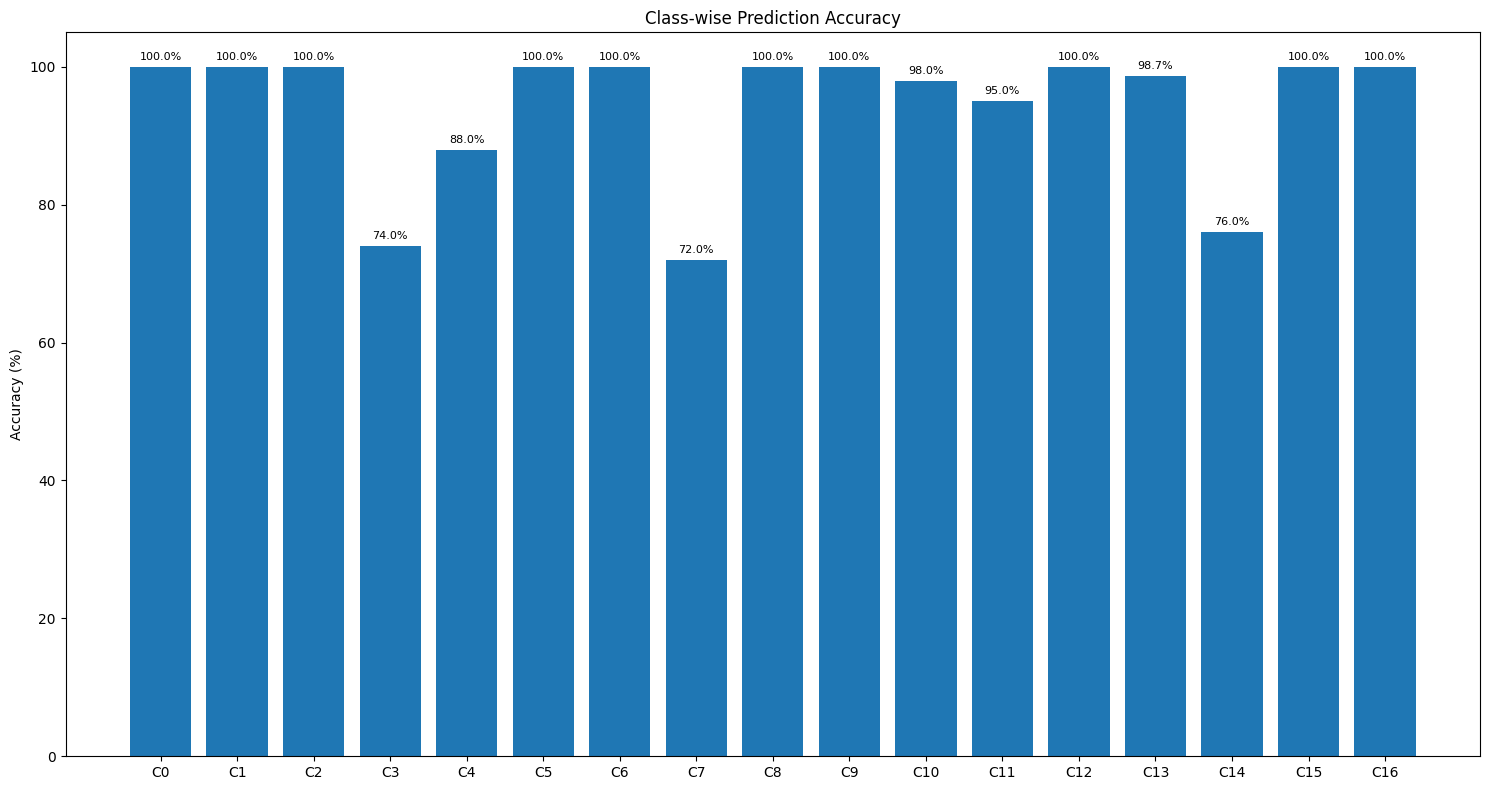

Worst 3 classes:
Class 7: 72.0%
Class 3: 74.0%
Class 14: 76.0%


In [12]:
# 클래스별 성능 시각화
meta_df = pd.read_csv("../data/meta.csv")
avg_acc = {c: np.mean([f.get(c,0) for f in fold_class_accuracies]) for c in range(17)}

plt.figure(figsize=(15, 8))
classes = list(avg_acc.keys())
accs = [avg_acc[c] * 100 for c in classes]
names = [f"C{c}" for c in classes]

plt.bar(range(17), accs)
plt.xticks(range(17), names)
plt.ylabel('Accuracy (%)')
plt.title('Class-wise Prediction Accuracy')
for i, acc in enumerate(accs):
    plt.text(i, acc + 1, f'{acc:.1f}%', ha='center', fontsize=8)
plt.tight_layout()
plt.show()

print("Worst 3 classes:")
worst = sorted(avg_acc.items(), key=lambda x: x[1])[:3]
for c, acc in worst:
    print(f"Class {c}: {acc*100:.1f}%")

In [13]:
# 5-Fold 앙상블 모델 준비
ensemble_models = []
for i, state_dict in enumerate(fold_models):
    fold_model = timm.create_model(model_name, pretrained=True, num_classes=17).to(device)
    fold_model.load_state_dict(state_dict)
    fold_model.eval()
    ensemble_models.append(fold_model)
print(f"Using ensemble of all {len(ensemble_models)} fold models for inference")

Using ensemble of all 5 fold models for inference


## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [14]:
# # load model
# model = timm.create_model(
#     model_name,
#     pretrained=True,
#     num_classes=17
# ).to(device)
# loss_fn = nn.CrossEntropyLoss()
# optimizer = Adam(model.parameters(), lr=LR)

In [15]:
# for epoch in range(EPOCHS):
#     ret = train_one_epoch(trn_loader, model, optimizer, loss_fn, device=device)
#     ret['epoch'] = epoch

#     log = ""
#     for k, v in ret.items():
#       log += f"{k}: {v:.4f}\n"
#     print(log)

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [16]:
# preds_list = []

# model.eval()
# for image, _ in tqdm(tst_loader):
#     image = image.to(device)

#     with torch.no_grad():
#         preds = model(image)
#     preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())

In [17]:
# pred_df = pd.DataFrame(tst_dataset.df, columns=['ID', 'target'])
# pred_df['target'] = preds_list

In [18]:
# sample_submission_df = pd.read_csv("../data/sample_submission.csv")
# assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [19]:
# pred_df.to_csv("pred.csv", index=False)

In [20]:
# Temperature Scaling 클래스 정의
class TemperatureScaling(nn.Module):
    def __init__(self):
        super().__init__()
        self.temperature = nn.Parameter(torch.ones(1) * 1.5)
    
    def forward(self, logits):
        return logits / self.temperature

In [21]:
essential_tta_transforms = [
    # 원본
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 90도 회전들
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[90, 90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[180, 180], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.Rotate(limit=[-90, -90], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
    # 밝기 개선
    A.Compose([
        A.LongestMaxSize(max_size=img_size),
        A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=0),
        A.RandomBrightnessContrast(brightness_limit=[0.3, 0.3], contrast_limit=[0.3, 0.3], p=1.0),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ]),
]

In [22]:
# TTA 추론을 위한 Dataset 클래스
class TTAImageDataset(Dataset):
    def __init__(self, data, path, transforms):
        if isinstance(data, str):
            self.df = pd.read_csv(data).values
        else:
            self.df = data.values
        self.path = path
        self.transforms = transforms  # 여러 transform을 리스트로 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        
        # 모든 transform을 적용한 결과를 리스트로 반환
        augmented_images = []
        for transform in self.transforms:
            aug_img = transform(image=img)['image']
            augmented_images.append(aug_img)
        
        return augmented_images, target

In [23]:
# TTA Dataset 생성
tta_dataset = TTAImageDataset(
    "../data/sample_submission.csv",
    "../data/test/",
    essential_tta_transforms
)

# TTA DataLoader (배치 크기를 줄여서 메모리 절약)
tta_loader = DataLoader(
    tta_dataset,
    batch_size=64,  # TTA는 메모리를 많이 사용하므로 배치 크기 줄임
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

print(f"TTA Dataset size: {len(tta_dataset)}")

TTA Dataset size: 3140


In [24]:
def ensemble_tta_inference(models, loader, transforms, confidence_threshold=0.9):
    """5-Fold 모델 앙상블 + TTA 추론"""
    all_predictions = []
    
    for batch_idx, (images_list, _) in enumerate(tqdm(loader, desc="Ensemble TTA")):
        batch_size = images_list[0].size(0)
        ensemble_probs = torch.zeros(batch_size, 17).to(device)
        
        # 각 fold 모델별 예측
        for model in models:
            with torch.no_grad():
                # 각 TTA 변형별 예측
                for images in images_list:
                    images = images.to(device)
                    preds = model(images)
                    probs = torch.softmax(preds, dim=1)
                    ensemble_probs += probs / (len(models) * len(images_list))
        
        final_preds = torch.argmax(ensemble_probs, dim=1)
        all_predictions.extend(final_preds.cpu().numpy())
    
    return all_predictions

In [25]:
# 앙상블 TTA 실행
print("Starting Ensemble TTA inference...")
tta_predictions = ensemble_tta_inference(
    models=ensemble_models, 
    loader=tta_loader, 
    transforms=essential_tta_transforms,
    confidence_threshold=0.9
)

Starting Ensemble TTA inference...


Ensemble TTA: 100%|██████████| 50/50 [13:15<00:00, 15.90s/it]


In [26]:
# TTA 결과로 submission 파일 생성
tta_pred_df = pd.DataFrame(tta_dataset.df, columns=['ID', 'target'])
tta_pred_df['target'] = tta_predictions

In [27]:
# 기존 submission과 동일한 순서인지 확인
sample_submission_df = pd.read_csv("../data/sample_submission.csv")
assert (sample_submission_df['ID'] == tta_pred_df['ID']).all()

In [28]:
# TTA 결과 저장
tta_pred_df.to_csv("../submission/choice.csv", index=False)
print("TTA predictions saved")

print("TTA Prediction sample:")

TTA predictions saved
TTA Prediction sample:


In [ ]:
# [추가] 최종 실험 결과 저장
# K-Fold 교차검증 결과 저장
try:
    # K-Fold 결과 요약
    kfold_summary = {
        'n_folds': N_FOLDS,
        'avg_val_f1': np.mean([result['best_val_f1'] for result in fold_results]),
        'std_val_f1': np.std([result['best_val_f1'] for result in fold_results]),
        'fold_results': fold_results
    }
    
    # K-Fold 결과 저장
    logger.save_json(kfold_summary, 'kfold_results', 'K-Fold 교차검증 결과')
    
    # TTA 예측 결과 데이터프레임 저장
    logger.save_dataframe(tta_pred_df, 'tta_predictions', 'TTA 앙상블 예측 결과')
    
    # 최종 성능 메트릭 저장
    final_metrics = {
        'model_name': model_name,
        'final_cv_f1': np.mean([result['best_val_f1'] for result in fold_results]),
        'total_folds': N_FOLDS,
        'submission_file': 'choice.csv',
        'tta_enabled': True,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    logger.save_json(final_metrics, 'final_performance', '최종 성능 메트릭')
    
    print("✅ 모든 실험 결과 저장 완료!")
    print(f"📊 평균 CV F1: {final_metrics['final_cv_f1']:.4f}")
    
except Exception as e:
    print(f"⚠️ 결과 저장 중 오류: {e}")
    print("변수들이 정의되지 않았을 수 있습니다. 전체 노트북을 실행한 후 다시 시도해주세요.")

In [29]:
tta_pred_df.head()

,ID,target
0,0008fdb22ddce0ce.jpg,2
1,00091bffdffd83de.jpg,12
2,00396fbc1f6cc21d.jpg,5
3,00471f8038d9c4b6.jpg,12
4,00901f504008d884.jpg,2


In [ ]:
# [추가] 노트북 작업 완료 및 요약
print("\n" + "="*60)
print("🏁 KBH F1_0.934 Swin-B 노트북 작업 완료!")
print("="*60)

# 로거 정보 출력
logger.print_summary()

print("\n📄 생성된 주요 결과:")
print("   ✅ K-Fold 교차검증 결과")
print("   ✅ TTA 앙상블 예측 결과") 
print("   ✅ 하이퍼파라미터 설정")
print("   ✅ 최종 성능 메트릭")
print("   ✅ 제출용 CSV 파일: choice.csv")

print(f"\n💾 모든 결과는 다음 디렉토리에 저장되었습니다:")
print(f"   📁 {logger.log_dir}")

print("\n🎯 이 노트북은 팀 노트북 통합 모듈화 프로젝트의 일환으로 업데이트되었습니다.")